<a href="https://colab.research.google.com/github/salexashenko/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/module2-sampling-confidence-intervals-and-hypothesis-testing/LS_DS_132_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [1]:
import pandas as pd
from scipy.stats import ttest_ind
df=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data', na_values="?", header=None)
df.columns=['party','handicapped-infants','water-project-cost-sharing',
            'adoption-of-the-budget-resolution','physician-fee-freeze',
            'el-salvador-aid', 'religious-groups-in-schools',
            'anti-satellite-test-ban','aid-to-nicaraguan-contras',
            'mx-missile','immigration','synfuels-corporation-cutback',
            'education-spending','superfund-right-to-sue','crime',
            'duty-free-exports','export-administration-act-south-africa']
df=df.replace('y',1)
df=df.replace('n',0)
df.head()

,party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [0]:
import scipy.stats
import numpy as np
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [0]:
def conf_interval_clean(df,column):
    df_1=df[['party',column]]
    df_1=df_1.dropna()
    return mean_confidence_interval(df_1[column])

In [11]:
ci_water_project=conf_interval_clean(df,'water-project-cost-sharing')
ci_water_project

(0.5038759689922481, 0.45384081311663604, 0.5539111248678601)

<ErrorbarContainer object of 3 artists>

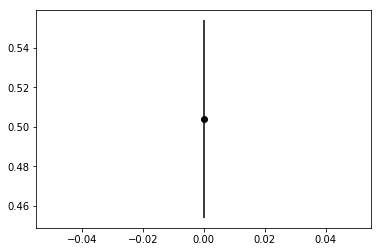

In [15]:
import matplotlib.pyplot as plt
mean1,lb,hb=ci_water_project

plt.figure()
plt.errorbar(0, mean1, yerr=[[mean1-lb], [hb-mean1]], fmt = 'o', color = 'k')


In [0]:
#We are very certain that the voting members are evenly split on the issue

In [16]:
!wget https://resources.lendingclub.com/LoanStats_2018Q4.csv.zip
!unzip LoanStats_2018Q4.csv.zip
!head LoanStats_2018Q4.csv
import pandas as pd
df = pd.read_csv('LoanStats_2018Q4.csv', header=1, skipfooter=2)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
df=df.drop(columns=['id','desc','member_id','url'])
df.isna().sum().sort_values(ascending = False)
def depercentify(s):
  s=s[:-1]
  i=float(s)
  return i
df['int_rate'] = df['int_rate'].apply(depercentify)
import numpy as np
examples = ['owner','Supervisor',' Project Manager',np.NaN]
def clean_title(title):
  if(isinstance(title, float)):
    return "Unknown"
  else:
    title=title.strip()
    title=title.title()
    return title
df['emp_title'] = df['emp_title'].apply(clean_title)
df['emp_title_manager'] = True
df['emp_title_manager'] = df['emp_title'].str.contains('Manager')

--2019-09-16 15:48:24--  https://resources.lendingclub.com/LoanStats_2018Q4.csv.zip
Resolving resources.lendingclub.com (resources.lendingclub.com)... 64.48.1.20
Connecting to resources.lendingclub.com (resources.lendingclub.com)|64.48.1.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘LoanStats_2018Q4.csv.zip’

LoanStats_2018Q4.cs     [                 <=>]  21.58M   842KB/s    in 27s     

2019-09-16 15:48:51 (831 KB/s) - ‘LoanStats_2018Q4.csv.zip’ saved [22631049]

Archive:  LoanStats_2018Q4.csv.zip
  inflating: LoanStats_2018Q4.csv    
Notes offered by Prospectus (https://www.lendingclub.com/info/prospectus.action)
"id","member_id","loan_amnt","funded_amnt","funded_amnt_inv","term","int_rate","installment","grade","sub_grade","emp_title","emp_length","home_ownership","annual_inc","verification_status","issue_d","loan_status","pymnt_plan","url","desc","purpose","title","zip_code","addr_state","dti","delinq_2yrs","

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  """


In [17]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,emp_title_manager
0,10000,10000,10000.0,36 months,10.33,324.23,B,B1,Unknown,< 1 year,MORTGAGE,280000.0,Not Verified,Dec-2018,Current,n,debt_consolidation,Debt consolidation,974xx,OR,6.15,2,Jan-1996,0,18.0,NaN,14,0,9082,38%,23,w,8289.30,8289.30,2261.00,2261.00,1710.70,550.30,0.0,0.0,0.0,Jul-2019,324.23,Sep-2019,Aug-2019,0,NaN,1,Individual,NaN,NaN,NaN,0,671,246828,1,3,2,3,1.0,48552,62.0,1,3,4923,46.0,23900,2,7,1,7,17631.0,11897.0,43.1,0,0,158.0,275,11,1,1,11.0,NaN,11.0,NaN,0,3,4,7,7,10,9,11,4,14,0.0,0,0,4,91.3,28.6,0,0,367828,61364,20900,54912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,False
1,4000,4000,4000.0,36 months,23.40,155.68,E,E1,Security,3 years,RENT,90000.0,Source Verified,Dec-2018,Current,n,debt_consolidation,Debt consolidation,070xx,NJ,26.33,0,Sep-2006,4,59.0,NaN,15,0,5199,19.2%,20,w,3423.38,3423.38,1081.96,1081.96,576.62,505.34,0.0,0.0,0.0,Jul-2019,155.68,Sep-2019,Aug-2019,0,NaN,1,Individual,NaN,NaN,NaN,0,0,66926,5,4,3,4,5.0,61727,86.0,6,11,1353,68.0,27100,4,0,4,15,4462.0,20174.0,7.9,0,0,147.0,118,2,2,0,2.0,NaN,0.0,NaN,0,5,7,9,9,8,11,12,7,15,0.0,0,0,9,95.0,0.0,0,0,98655,66926,21900,71555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,False
2,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,Dec-2018,Late (31-120 days),n,debt_consolidation,Debt consolidation,490xx,MI,10.51,0,Apr-2011,0,NaN,NaN,8,0,4599,19.1%,13,w,4456.17,4456.17,895.96,895.96,543.83,352.13,0.0,0.0,0.0,Jun-2019,180.69,Sep-2019,Aug-2019,0,NaN,1,Individual,NaN,NaN,NaN,0,0,110299,0,1,0,2,14.0,7150,72.0,0,2,0,35.0,24100,1,5,

In [23]:
gb=df.groupby(by=['home_ownership','purpose']).size().unstack(level=1, fill_value=0)
gb

purpose,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation
home_ownership,,,,,,,,,,,,
ANY,1,132,169,5,1,1,0,1,23,0,0,0
MORTGAGE,489,16164,34804,5795,439,1036,719,141,3063,37,472,331
OWN,111,3598,7584,1039,149,290,188,29,795,8,116,86
RENT,436,15067,28046,673,234,976,592,485,3213,26,463,385


In [24]:
gb.sum()

purpose
car                    1037
credit_card           34961
debt_consolidation    70603
home_improvement       7512
house                   823
major_purchase         2303
medical                1499
moving                  656
other                  7094
renewable_energy         71
small_business         1051
vacation                802
dtype: int64

In [26]:
gb.sum(axis=1)

home_ownership
ANY           333
MORTGAGE    63490
OWN         13993
RENT        50596
dtype: int64

In [29]:
total=333+63490+13993+50596
frequencies=[333/total,63490/total,13993/total,50596/total]
frequencies

[0.002593215587328287,
 0.49442419711553437,
 0.10896956670716132,
 0.394013020589976]

In [0]:
home_improvement_total=7512
expected=[i * home_improvement_total for i in frequencies]


In [38]:
import numpy as np
expected = np.asarray(expected)
actual=gb['home_improvement'].values
actual

array([   5, 5795, 1039,  673])

In [41]:
residual=actual-expected
residual

array([  -14.48023549,  2080.88543127,   220.4206149 , -2286.82581067])

In [42]:
residual_sq=residual*residual
residual_sq

array([2.09677220e+02, 4.33008418e+06, 4.85852475e+04, 5.22957229e+06])

In [43]:
component=residual_sq/expected
component

array([  10.76358753, 1165.84561352,   59.35312855, 1766.85136994])

In [45]:
chi_sq=component.sum()
chi_sq

3002.813699536806

In [46]:
from scipy.stats import chisquare
chisquare(actual, f_exp=expected)

Power_divergenceResult(statistic=3002.813699536806, pvalue=0.0)

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

In [0]:
ea

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)